### Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_forecasting-USU/blob/main/Lectures%20and%20codes/DF%20Spring%202023/Module%207-%20Deep%20Sequence%20Modeling/Python/Module7_Univariate_RNN-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center) 


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 7: Deep Sequence Modeling (timeseries forecasting)

This module provides a comprehensive overview of fundamental concepts and techniques related to deep sequence modeling. Part one explores deep learning for timeseries data, highlighting the inadequacy of DNN and CNN architectures for this task and introducing the recurrent neural network (RNN) as a solution. 

# Installation

* If you want to run your code on Google Colab, there is no installation required. (recommended for the course)
* If you want to run your code locally, then you need to install tensorflow first: https://www.tensorflow.org/install


In [ ]:
import tensorflow 
tensorflow.__version__

'2.12.0'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/airline_passengers.csv", index_col="Month")
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [ ]:
# if you are working with Pandas, your first job should be changing the type of the index to datetime and then to period! This is a compatibility issue with other packages. 
df.index

Index(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
       '1949-07', '1949-08', '1949-09', '1949-10',
       ...
       '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
       '1960-09', '1960-10', '1960-11', '1960-12'],
      dtype='object', name='Month', length=144)

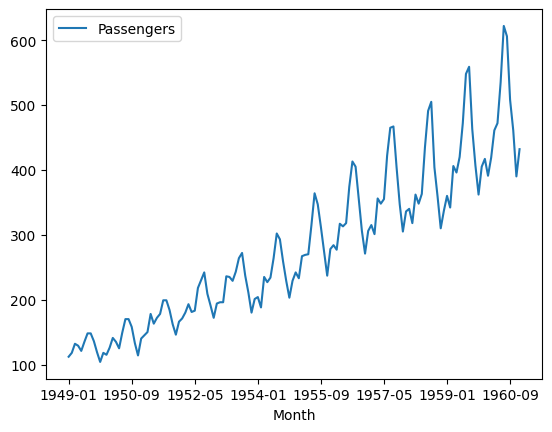

In [ ]:
df.plot()
plt.show()

## Splitting the data:

**Computing the number of samples we'll use for each data split** 

In [ ]:
len(df)

144

In [ ]:
num_train_samples = int(0.6 * len(df))
num_val_samples = int(0.20 * len(df))
num_test_samples = len(df) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 86
num_val_samples: 28
num_test_samples: 30


# Preparing the data

## Stationarity



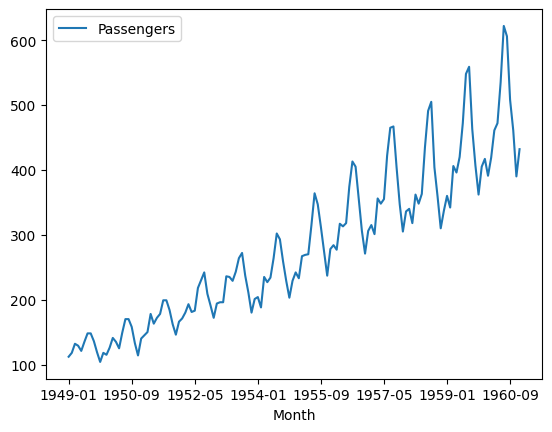

In [ ]:
df.plot()
plt.show()

In [ ]:
# the data is clearly not stationary. We will go ahead and use the log transformation and then first differencing
df['LogPassengers'] = np.log(df['Passengers'])
df['DiffLogPassengers']= df['LogPassengers'].diff(1)

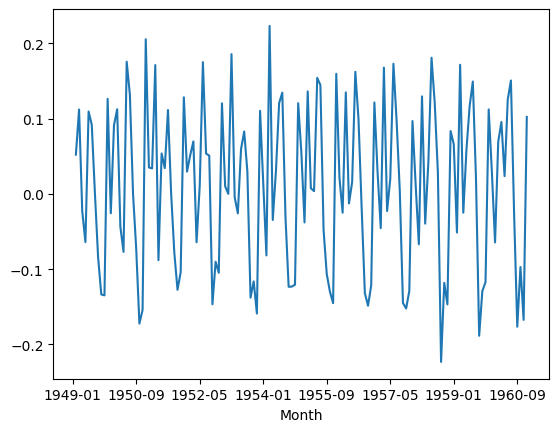

In [ ]:
df['DiffLogPassengers'].plot()
plt.show()

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.head()

,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-02,118,4.770685,0.052186
1949-03,132,4.882802,0.112117
1949-04,129,4.859812,-0.022990
1949-05,121,4.795791,-0.064022
1949-06,135,4.905275,0.109484




## Normalizing the data

In [ ]:
# in this example, because we work with stationary DiffLogPassengers, we don't need to normalize the data. If you want, you cant try running the following:

# mean = df[:num_train_samples].mean(axis=0)
# df -= mean
#std = df[:num_train_samples].std(axis=0)
# df /= std

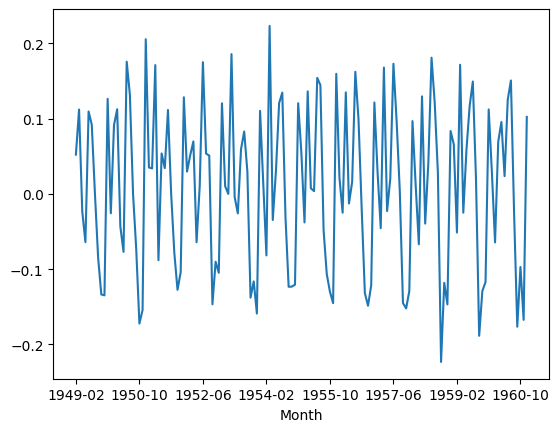

In [ ]:
df['DiffLogPassengers'].plot()
plt.show()

## Time series batch generator
**Instantiating datasets for training, validation, and testing**
https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(13)
batch_size = 1 # Number of timeseries samples in each batch (except maybe the last one). If None, the data will not be batched (the dataset will yield individual samples).
sequence_length = 3 # Length of the output sequences (in number of timesteps).
h = 1 # number of h steps ahead for forecasting
delay = sequence_length + h -1  # number of delayed timesteps to start predictions

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-delay],
    targets=int_sequence[delay:],
    sequence_length=sequence_length,
    sequence_stride= 1, # Number of timesteps between two consecutive output sequences.
    batch_size=batch_size, 
    shuffle = False, # Whether to shuffle output samples, or instead draw them in chronological order.
)

for inputs, targets in dummy_dataset:
  print(inputs, targets)

tf.Tensor([[0 1 2]], shape=(1, 3), dtype=int64) tf.Tensor([3], shape=(1,), dtype=int64)
tf.Tensor([[1 2 3]], shape=(1, 3), dtype=int64) tf.Tensor([4], shape=(1,), dtype=int64)
tf.Tensor([[2 3 4]], shape=(1, 3), dtype=int64) tf.Tensor([5], shape=(1,), dtype=int64)
tf.Tensor([[3 4 5]], shape=(1, 3), dtype=int64) tf.Tensor([6], shape=(1,), dtype=int64)
tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int64) tf.Tensor([7], shape=(1,), dtype=int64)
tf.Tensor([[5 6 7]], shape=(1, 3), dtype=int64) tf.Tensor([8], shape=(1,), dtype=int64)
tf.Tensor([[6 7 8]], shape=(1, 3), dtype=int64) tf.Tensor([9], shape=(1,), dtype=int64)
tf.Tensor([[7 8 9]], shape=(1, 3), dtype=int64) tf.Tensor([10], shape=(1,), dtype=int64)


Now, let's create our train, val and test datasets:

In [ ]:
len(df)

143

In [ ]:
# recall
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 86
num_val_samples: 28
num_test_samples: 30


In [ ]:
series = df['DiffLogPassengers']
sequence_length = 12 # using the past 12 months to predict next month. 
h = 1 
delay = sequence_length  + h - 1
batch_size = 32

train_dataset = keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
for inputs, targets in test_dataset:
  print(inputs, targets)

tf.Tensor(
[[-0.14675009  0.08351063  0.0660211  -0.05129329  0.17154242 -0.02493895
   0.0588405   0.11672427  0.1492963   0.01987419 -0.18842242 -0.12891387]
 [ 0.08351063  0.0660211  -0.05129329  0.17154242 -0.02493895  0.0588405
   0.11672427  0.1492963   0.01987419 -0.18842242 -0.12891387 -0.11716897]
 [ 0.0281143  -0.22314355 -0.11809249 -0.14675009  0.08351063  0.0660211
  -0.05129329  0.17154242 -0.02493895  0.0588405   0.11672427  0.1492963 ]
 [-0.22314355 -0.11809249 -0.14675009  0.08351063  0.0660211  -0.05129329
   0.17154242 -0.02493895  0.0588405   0.11672427  0.1492963   0.01987419]
 [ 0.0660211  -0.05129329  0.17154242 -0.02493895  0.0588405   0.11672427
   0.1492963   0.01987419 -0.18842242 -0.12891387 -0.11716897  0.11224286]
 [-0.11809249 -0.14675009  0.08351063  0.0660211  -0.05129329  0.17154242
  -0.02493895  0.0588405   0.11672427  0.1492963   0.01987419 -0.18842242]], shape=(6, 12), dtype=float64) tf.Tensor([-0.11716897  0.11224286  0.01987419 -0.18842242  0.029

In [ ]:
series.iloc[num_train_samples + num_val_samples:]

Month
1958-08    0.028114
1958-09   -0.223144
1958-10   -0.118092
1958-11   -0.146750
1958-12    0.083511
1959-01    0.066021
1959-02   -0.051293
1959-03    0.171542
1959-04   -0.024939
1959-05    0.058841
1959-06    0.116724
1959-07    0.149296
1959-08    0.019874
1959-09   -0.188422
1959-10   -0.128914
1959-11   -0.117169
1959-12    0.112243
1960-01    0.029199
1960-02   -0.064379
1960-03    0.069163
1960-04    0.095527
1960-05    0.023581
1960-06    0.125288
1960-07    0.150673
1960-08   -0.026060
1960-09   -0.176399
1960-10   -0.097083
1960-11   -0.167251
1960-12    0.102279
Name: DiffLogPassengers, dtype: float64

In [ ]:
for samples, targets in train_dataset.take(1):
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    

samples shape: (32, 12)
targets shape: (32,)


# A common-sense, non-machine-learning baseline

In [ ]:
for inputs, targets in test_dataset:
  print(inputs.shape, inputs, targets)

(6, 12) tf.Tensor(
[[ 0.08351063  0.0660211  -0.05129329  0.17154242 -0.02493895  0.0588405
   0.11672427  0.1492963   0.01987419 -0.18842242 -0.12891387 -0.11716897]
 [ 0.0660211  -0.05129329  0.17154242 -0.02493895  0.0588405   0.11672427
   0.1492963   0.01987419 -0.18842242 -0.12891387 -0.11716897  0.11224286]
 [-0.11809249 -0.14675009  0.08351063  0.0660211  -0.05129329  0.17154242
  -0.02493895  0.0588405   0.11672427  0.1492963   0.01987419 -0.18842242]
 [ 0.0281143  -0.22314355 -0.11809249 -0.14675009  0.08351063  0.0660211
  -0.05129329  0.17154242 -0.02493895  0.0588405   0.11672427  0.1492963 ]
 [-0.22314355 -0.11809249 -0.14675009  0.08351063  0.0660211  -0.05129329
   0.17154242 -0.02493895  0.0588405   0.11672427  0.1492963   0.01987419]
 [-0.14675009  0.08351063  0.0660211  -0.05129329  0.17154242 -0.02493895
   0.0588405   0.11672427  0.1492963   0.01987419 -0.18842242 -0.12891387]], shape=(6, 12), dtype=float64) tf.Tensor([ 0.11224286  0.02919915 -0.12891387  0.0198741

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1] # naive forecast is the last value observed in the sequence
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0] # number of samples in the batch
    return total_abs_err / samples_seen


In [ ]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

# the unit is DiffLogPassengers

Validation MAE: 0.11
Test MAE: 0.12


# Simple RNN

In [ ]:
from tensorflow.keras import layers

In [ ]:
sequence_length

12

In [ ]:
n_features = 1

In [ ]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.SimpleRNN(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary() 


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                288       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# parameters = (1 (feature) * 16 (cells) ) + (16 * 16) hidden state weight matrix + 16 bias terms
1*16 + 16*16 + 16

288

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("RNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/100
3/3 [==============================] - 6s 137ms/step - loss: 0.0147 - mae: 0.0980 - val_loss: 0.0057 - val_mae: 0.0593
Epoch 2/100
3/3 [==============================] - 0s 32ms/step - loss: 0.0098 - mae: 0.0771 - val_loss: 0.0049 - val_mae: 0.0554
Epoch 3/100
3/3 [==============================] - 0s 37ms/step - loss: 0.0082 - mae: 0.0747 - val_loss: 0.0032 - val_mae: 0.0439
Epoch 4/100
3/3 [==============================] - 0s 32ms/step - loss: 0.0072 - mae: 0.0675 - val_loss: 0.0025 - val_mae: 0.0386
Epoch 5/100
3/3 [==============================] - 0s 27ms/step - loss: 0.0067 - mae: 0.0646 - val_loss: 0.0027 - val_mae: 0.0426
Epoch 6/100
3/3 [==============================] - 0s 36ms/step - loss: 0.0063 - mae: 0.0638 - val_loss: 0.0021 - val_mae: 0.0359
Epoch 7/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0060 - mae: 0.0619 - val_loss: 0.0027 - val_mae: 0.0419
Epoch 8/100
3/3 [==============================] - 0s 27ms/step - loss: 0.0058 - mae: 0.0

In [ ]:
model = keras.models.load_model("RNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")

1/1 [==============================] - 0s 184ms/step - loss: 6.8486e-04 - mae: 0.0212
Test MAE: 0.021


In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.tail()


,loss,mae,val_loss,val_mae
95,0.002307,0.038167,0.000908,0.026754
96,0.002355,0.038145,0.000449,0.018778
97,0.002331,0.038379,0.000379,0.016587
98,0.002302,0.037889,0.000786,0.025891
99,0.002412,0.038764,0.000552,0.020924


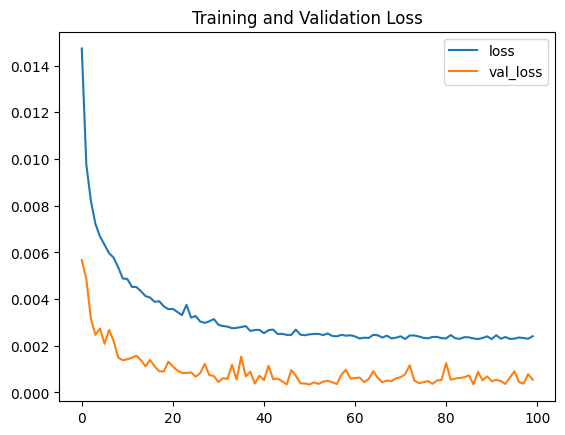

In [ ]:
import matplotlib.pyplot as plt

loss_df[['loss', 'val_loss']].plot(legend=True, title='Training and Validation Loss')
plt.show()

#  LSTM 

In [ ]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary() 


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# parameters = [(1 (feature) * 16 (cells) ) + (16 * 16) hidden state weight matrix + 16 bias terms ] * 4 gates
(1*16 + 16*16 + 16) *4

1152

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("LSTM.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=200,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/200
3/3 [==============================] - 3s 219ms/step - loss: 0.0105 - mae: 0.0856 - val_loss: 0.0103 - val_mae: 0.0829
Epoch 2/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0105 - mae: 0.0853 - val_loss: 0.0102 - val_mae: 0.0826
Epoch 3/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0106 - mae: 0.0857 - val_loss: 0.0103 - val_mae: 0.0830
Epoch 4/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0106 - mae: 0.0861 - val_loss: 0.0102 - val_mae: 0.0825
Epoch 5/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0104 - mae: 0.0854 - val_loss: 0.0102 - val_mae: 0.0825
Epoch 6/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0104 - mae: 0.0851 - val_loss: 0.0103 - val_mae: 0.0839
Epoch 7/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0103 - mae: 0.0847 - val_loss: 0.0101 - val_mae: 0.0823
Epoch 8/200
3/3 [==============================] - 0s 21ms/step - loss: 0.0103 - mae: 0.0

In [ ]:
model = keras.models.load_model("LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")

1/1 [==============================] - 1s 632ms/step - loss: 0.0043 - mae: 0.0501
Test MAE: 0.050


In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df.tail()


,loss,mae,val_loss,val_mae
195,0.005293,0.058658,0.005665,0.064590
196,0.005557,0.060001,0.005579,0.062609
197,0.005228,0.058065,0.005815,0.063975
198,0.005428,0.058771,0.007180,0.068043
199,0.005778,0.063285,0.005562,0.062112


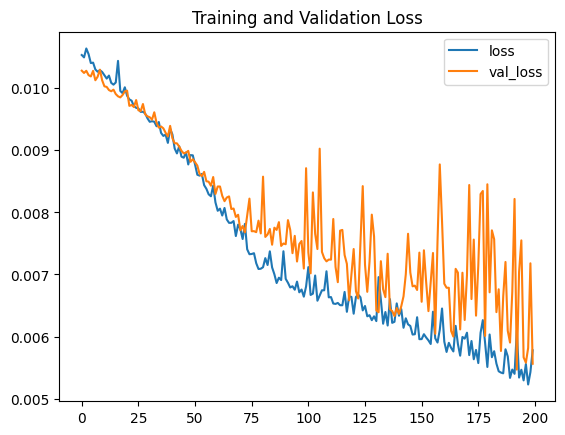

In [ ]:
import matplotlib.pyplot as plt

loss_df[['loss', 'val_loss']].plot(legend=True, title='Training and Validation Loss')
plt.show()

# More complex models with regularization

In [ ]:
# We can stack multiple LSTM layers and add regularization.  

inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.SimpleRNN(32, recurrent_dropout=0.1, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, recurrent_dropout=0.1)(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("RNN_stacked_regularized.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/100
3/3 [==============================] - 3s 191ms/step - loss: 0.2017 - mae: 0.3728 - val_loss: 0.0629 - val_mae: 0.2207
Epoch 2/100
3/3 [==============================] - 0s 60ms/step - loss: 0.0888 - mae: 0.2440 - val_loss: 0.0393 - val_mae: 0.1860
Epoch 3/100
3/3 [==============================] - 0s 54ms/step - loss: 0.1083 - mae: 0.2794 - val_loss: 0.0145 - val_mae: 0.0894
Epoch 4/100
3/3 [==============================] - 0s 57ms/step - loss: 0.0710 - mae: 0.2096 - val_loss: 0.0097 - val_mae: 0.0797
Epoch 5/100
3/3 [==============================] - 0s 54ms/step - loss: 0.0613 - mae: 0.1988 - val_loss: 0.0081 - val_mae: 0.0742
Epoch 6/100
3/3 [==============================] - 0s 50ms/step - loss: 0.0597 - mae: 0.2076 - val_loss: 0.0118 - val_mae: 0.0883
Epoch 7/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0461 - mae: 0.1763 - val_loss: 0.0062 - val_mae: 0.0664
Epoch 8/100
3/3 [==============================] - 0s 67ms/step - loss: 0.0388 - mae: 0.1

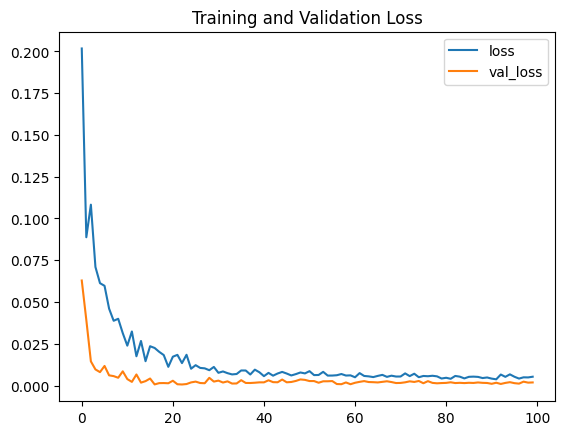

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df[['loss', 'val_loss']].plot(legend=True, title='Training and Validation Loss')
plt.show()

In [ ]:
model = keras.models.load_model("RNN_stacked_regularized.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")


1/1 [==============================] - 0s 402ms/step - loss: 6.1041e-04 - mae: 0.0208
Test MAE: 0.021


# Bidirectional RNN? 

In [ ]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.Bidirectional(layers.SimpleRNN(32))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("bidirectional_RNN.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset, 
                    callbacks=callbacks)

Epoch 1/100
3/3 [==============================] - 4s 171ms/step - loss: 0.0185 - mae: 0.1148 - val_loss: 0.0051 - val_mae: 0.0590
Epoch 2/100
3/3 [==============================] - 0s 62ms/step - loss: 0.0060 - mae: 0.0604 - val_loss: 0.0027 - val_mae: 0.0427
Epoch 3/100
3/3 [==============================] - 0s 46ms/step - loss: 0.0036 - mae: 0.0475 - val_loss: 0.0021 - val_mae: 0.0376
Epoch 4/100
3/3 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.0464 - val_loss: 0.0023 - val_mae: 0.0415
Epoch 5/100
3/3 [==============================] - 0s 44ms/step - loss: 0.0025 - mae: 0.0388 - val_loss: 0.0018 - val_mae: 0.0374
Epoch 6/100
3/3 [==============================] - 0s 43ms/step - loss: 0.0024 - mae: 0.0390 - val_loss: 4.4897e-04 - val_mae: 0.0173
Epoch 7/100
3/3 [==============================] - 0s 44ms/step - loss: 0.0029 - mae: 0.0423 - val_loss: 0.0025 - val_mae: 0.0430
Epoch 8/100
3/3 [==============================] - 0s 51ms/step - loss: 0.0031 - mae:

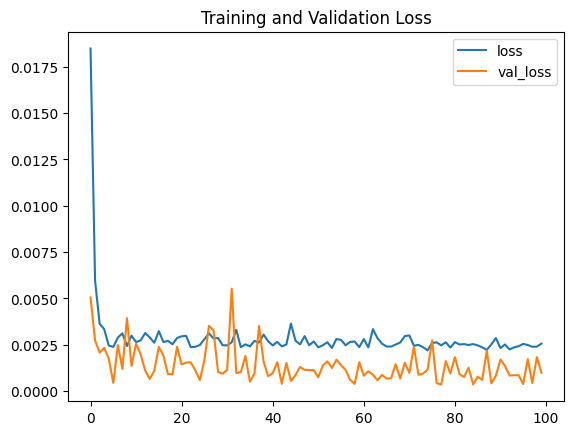

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df[['loss', 'val_loss']].plot(legend=True, title='Training and Validation Loss')
plt.show()

In [ ]:
model = keras.models.load_model("bidirectional_RNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")


1/1 [==============================] - 0s 280ms/step - loss: 7.3643e-04 - mae: 0.0194
Test MAE: 0.019


# Comparing Econometrics vs Machine Learning vs Deep Learning for univariate timeseries forecasting. 

**Benchmarks** 
* Seasonal Naive Forecaster test MAE = 0.023
* Naive Forecaster test MAE = 0.11

**Econometrics** 
* Auto ARIMA test MAE = 0.023
* Auto ETS test MAE = 0.030

**Machine Learning** 
* Catboost test MAE = 0.025
* LightGBM test MAE = 0.028
* XGboost test MAE = 0.03
* Random Forest test MAE = 0.03

**Deep Learning** 
* simple RNN test MAE = 0.014
* Simple LSTM test MAE = 0.049
* Stacked RNN with regularization = 0.02
* Bidirectional RNN test MAE = 0.019

# Done!